# Neural network classification with PyTorch

### Make classification data and get it ready

In [116]:
import sklearn

In [117]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [118]:
len(X), len(y)

(1000, 1000)

In [119]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 sample of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 sample of y: [1 1 1 1 0]


In [120]:
# Make a DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2" : X[:, 1], "label" : y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


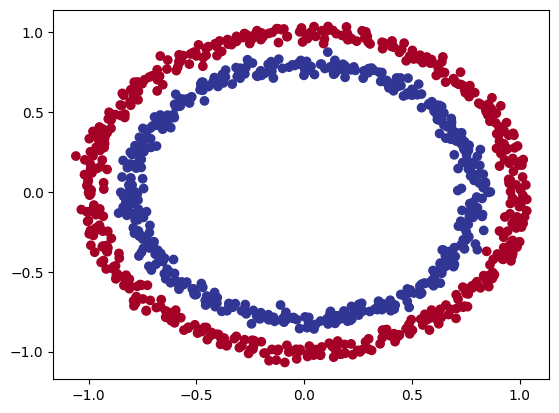

In [121]:
# Visualize visualize visualize

import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

## Check input and output shapes

In [122]:
X.shape, y.shape

((1000, 2), (1000,))

In [123]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [124]:
# View the first example of features and labels

X_sample = X[0]
y_sample = y[0]

X_sample, y_sample

(array([0.75424625, 0.23148074]), 1)

## Turn data into tensors and create train and test splits

In [125]:
import torch
torch.__version__

'2.6.0+cu126'

In [126]:
type(X)

numpy.ndarray

In [127]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [128]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [129]:
# Split data into training and test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [130]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building a model

Let's build a model to classify the dots.

In [131]:
# Import PyTorch and nn
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [132]:
X_train.shape

torch.Size([800, 2])

In [133]:
# Construct a model that subclasses the nn.module

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Create 2 nn.Linear layers and careful handling the shape of data
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    # Define a forward method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

# Intantiate an instance of our model class
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [134]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [135]:
# Replicate the model above using the nn.Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [136]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [137]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Lenght of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(torch.round(untrained_preds[:10])) 
print(y_test[:10])

Lenght of predictions: 200, Shape: torch.Size([200, 1])
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## Setup loss function and optimizer

Which loss function or optimizer should you use?

For regression you might want MAE or MSE

For classification you might want binary or categorical cross entropy.

In [138]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [139]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

## Train mode

### Going from raw logits -> prediction probabilities -> prediction labels

Logits are raw output of model without being passed to any activation functions

In [140]:
# View the first 5 op of the forward pass of the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [141]:
# Use the sigmoid activation(Used for binary classification) for our model logits.

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

### For prediction probability values, we need to perform range stype rounding 

- if >= 0.5 then 1
- if < 0.5 then 0

In [142]:
# Find the prediction labels
y_preds = torch.round(y_pred_probs)

# In full
with torch.inference_mode():
    y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True], device='cuda:0')


## Building a training and testing loop

In [143]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
    ## Training
    model_0.train()

    # Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    ## Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what is happening
    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69796, Acc: 51.88 | Test loss: 0.69440, Test acc: 58.00
Epoch: 10 | Loss: 0.69590, Acc: 51.25 | Test loss: 0.69305, Test acc: 53.00
Epoch: 20 | Loss: 0.69490, Acc: 51.62 | Test loss: 0.69254, Test acc: 49.50
Epoch: 30 | Loss: 0.69435, Acc: 51.12 | Test loss: 0.69236, Test acc: 49.50
Epoch: 40 | Loss: 0.69401, Acc: 50.88 | Test loss: 0.69232, Test acc: 51.00
Epoch: 50 | Loss: 0.69378, Acc: 50.25 | Test loss: 0.69234, Test acc: 50.00
Epoch: 60 | Loss: 0.69362, Acc: 50.00 | Test loss: 0.69239, Test acc: 51.50
Epoch: 70 | Loss: 0.69351, Acc: 50.25 | Test loss: 0.69246, Test acc: 51.00
Epoch: 80 | Loss: 0.69342, Acc: 49.88 | Test loss: 0.69254, Test acc: 50.00
Epoch: 90 | Loss: 0.69336, Acc: 49.88 | Test loss: 0.69262, Test acc: 53.00


## Make prediction and evaluate the model

Model is not learning anything.

Visualize visualize visualize

In [144]:
import requests
from pathlib import Path

# Download helper functions from LEarn PyTorch repo
if Path("helper_functions.py").is_file():
    print("helper_function.py already exists")
else:
    print("Donwloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_function.py already exists


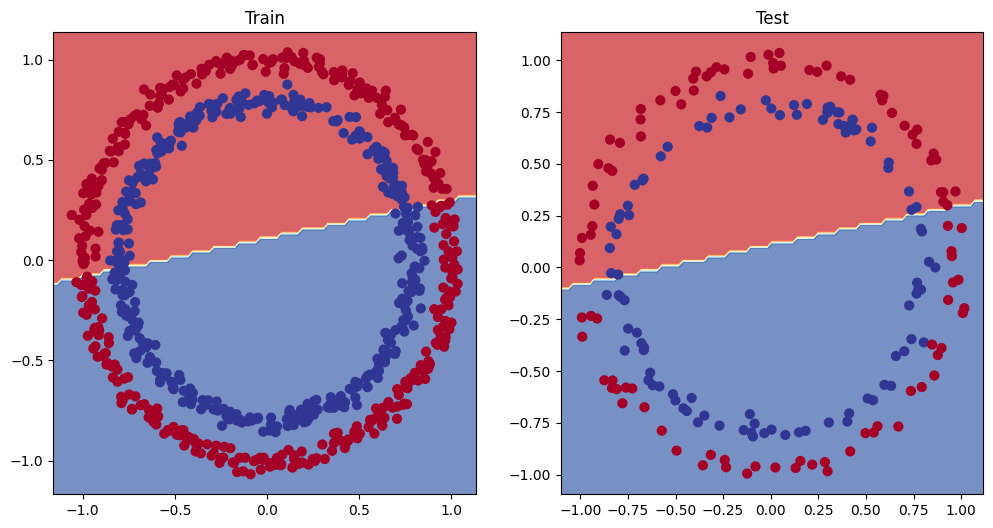

In [145]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving a model (From model perspective)

In [146]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x))) # This way of writing leverages speed ups wherever possible

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [147]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create a optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [148]:
# Write a trianing and evaluation loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    model_1.train()

    # Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate the loss and acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backwards
    loss.backward()

    # Optimizer step
    optimizer.step()

    ## Testing
    model_1.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print what is happening
    if epoch%100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc: 51.00
Epoch: 100 | Loss: 0.69305, Acc: 50.38 | Test loss: 0.69379, Test acc: 48.00
Epoch: 200 | Loss: 0.69299, Acc: 51.12 | Test loss: 0.69437, Test acc: 46.00
Epoch: 300 | Loss: 0.69298, Acc: 51.62 | Test loss: 0.69458, Test acc: 45.00
Epoch: 400 | Loss: 0.69298, Acc: 51.12 | Test loss: 0.69465, Test acc: 46.00
Epoch: 500 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69467, Test acc: 46.00
Epoch: 600 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epoch: 700 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epoch: 800 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epoch: 900 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00


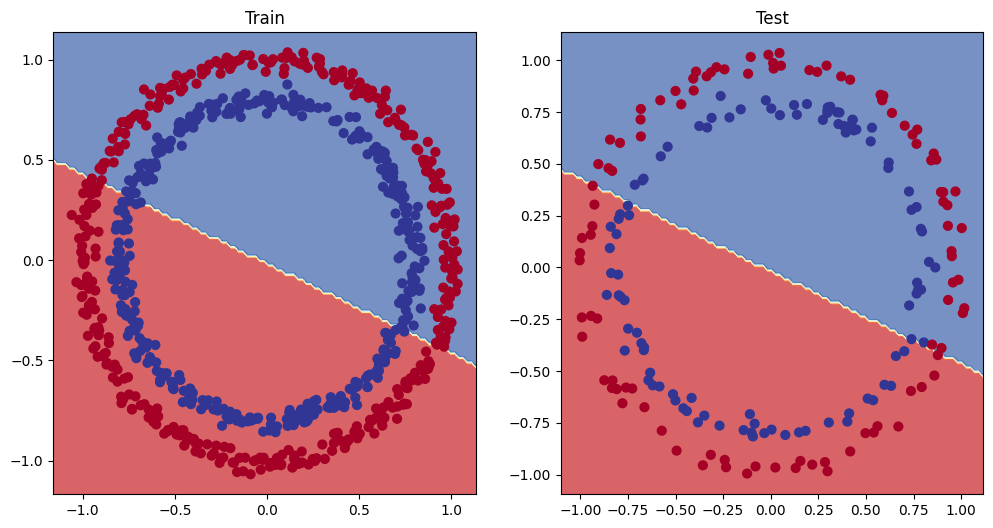

In [149]:
# plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## Prepare data to see if out model can fit a straight line

In [150]:
# Create some data (same as notebook 01)

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight*X_regression + bias

# check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [151]:
# create train and test split

train_split = int(0.8*len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the length of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

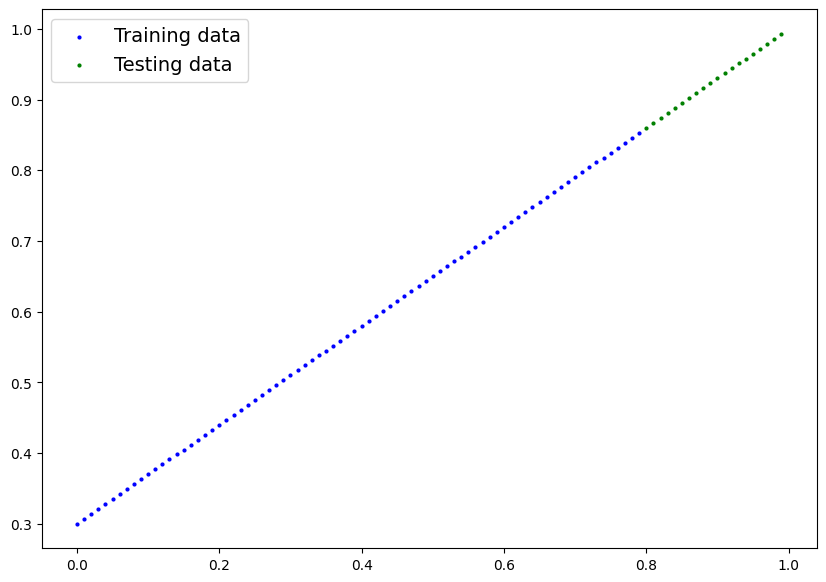

In [152]:
plot_predictions(train_data=X_train_regression, 
                 train_labels=y_train_regression, 
                 test_data=X_test_regression, 
                 test_labels=y_test_regression)

In [153]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

## Adjust model 1 to fit a straight line

In [154]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [155]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [156]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# training
for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # Print what is happening
    if epoch%100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


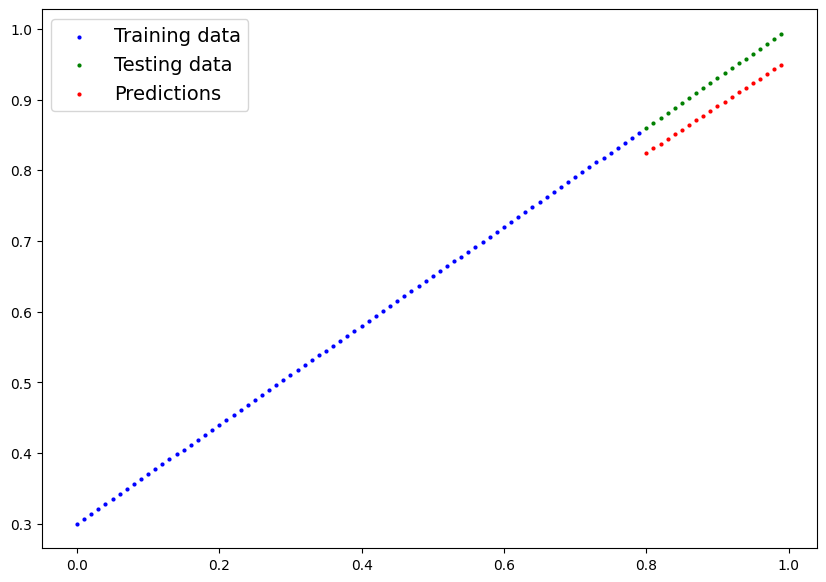

In [157]:
# Turn on evaluation mode
model_2.eval()
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                train_labels=y_train_regression.cpu(),
                test_data=X_test_regression.cpu(),
                test_labels=y_test_regression.cpu(),
                predictions=y_preds.cpu())

## Missing piece of our model was : Non-linearity

### Recreating non-linear data (red and blue circles)

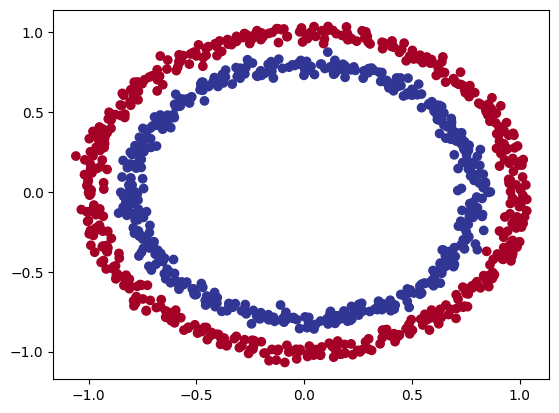

In [158]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                   noise = 0.03,
                   random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [159]:
# Convert data to tnesors and then train and test splits
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## Building a non linear model

In [160]:
# Build a model with non linear activations
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # A non linear activation

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [161]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

## Train model with non linearity

In [162]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1500

for epoch in range(epochs):
    model_3.train()

    # forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # optimizer step
    optimizer.step()

    # Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        # Print what is happening
    if epoch%100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69295, Acc: 50.00 | Test loss: 0.69319, Test acc: 50.00
Epoch: 100 | Loss: 0.69115, Acc: 52.88 | Test loss: 0.69102, Test acc: 52.50
Epoch: 200 | Loss: 0.68977, Acc: 53.37 | Test loss: 0.68940, Test acc: 55.00
Epoch: 300 | Loss: 0.68795, Acc: 53.00 | Test loss: 0.68723, Test acc: 56.00
Epoch: 400 | Loss: 0.68517, Acc: 52.75 | Test loss: 0.68411, Test acc: 56.50
Epoch: 500 | Loss: 0.68102, Acc: 52.75 | Test loss: 0.67941, Test acc: 56.50
Epoch: 600 | Loss: 0.67515, Acc: 54.50 | Test loss: 0.67285, Test acc: 56.00
Epoch: 700 | Loss: 0.66659, Acc: 58.38 | Test loss: 0.66322, Test acc: 59.00
Epoch: 800 | Loss: 0.65160, Acc: 64.00 | Test loss: 0.64757, Test acc: 67.50
Epoch: 900 | Loss: 0.62362, Acc: 74.00 | Test loss: 0.62145, Test acc: 79.00
Epoch: 1000 | Loss: 0.56818, Acc: 87.75 | Test loss: 0.57378, Test acc: 86.50
Epoch: 1100 | Loss: 0.48153, Acc: 93.50 | Test loss: 0.49935, Test acc: 90.50
Epoch: 1200 | Loss: 0.37056, Acc: 97.75 | Test loss: 0.40595, Test acc: 92.0

## Evaluate the model made with non linear activations

In [163]:
# Make predictions

model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

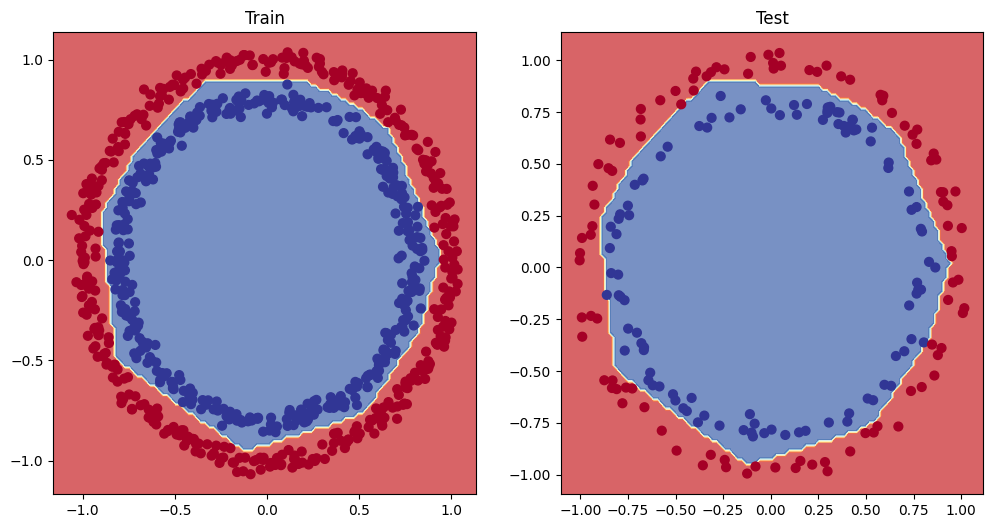

In [164]:
# plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## Replicating non-linear activation functions